<a href="https://colab.research.google.com/github/TheeGaurav/TheeGaurav/blob/main/volume_gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None
✅ Loading saved depth maps...


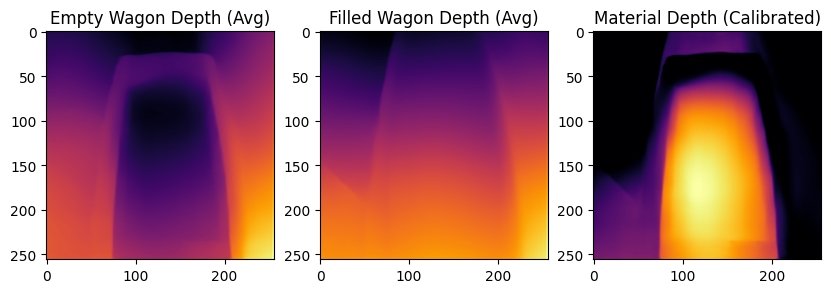

📌 Estimated volume of stored clinker: 45.17 cubic meters
📌 Estimated weight of stored clinker: 60.98 tons


In [7]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision.transforms import Compose, ToTensor, Normalize

# ✅ Load MiDaS Model (Faster `MiDaS_small` version)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small").to(device)  # Faster than DPT_Large
midas.eval()

# ✅ Optimize for PyTorch 2.0+
if torch.__version__ >= "2.0":
    midas = torch.compile(midas)

# ✅ Function to preprocess a frame (Reduced input size: 256x256)
def preprocess(frame, size=(256, 256)):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, size)  # Smaller input size = faster processing
    transform = Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    return transform(frame).unsqueeze(0).to(device)

# ✅ Function to process video and compute average depth (Processes every 5th frame)
def process_video(video_path, frame_skip=5, save_path=None):
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"❌ File not found: {video_path}")

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"❌ Could not open video: {video_path}")

    depth_maps = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_skip == 0:  # Skip frames to reduce processing
            img_tensor = preprocess(frame)
            with torch.no_grad():
                depth_map = midas(img_tensor).squeeze().cpu().numpy()
            depth_maps.append(depth_map)

        frame_count += 1

    cap.release()

    if len(depth_maps) == 0:
        raise ValueError("❌ No frames processed. Video might be empty or corrupted.")

    avg_depth_map = np.mean(depth_maps, axis=0)

    # ✅ Save depth map for later use
    if save_path:
        np.save(save_path, avg_depth_map)

    return avg_depth_map

# ✅ Load empty and filled wagon depth maps (Use saved files if available)
empty_wagon_path = '/content/sample_data/2.mp4'
filled_wagon_path = '/content/sample_data/5.mp4'

empty_depth_file = "empty_wagon_depth.npy"
filled_depth_file = "filled_wagon_depth.npy"

if os.path.exists(empty_depth_file) and os.path.exists(filled_depth_file):
    print("✅ Loading saved depth maps...")
    empty_wagon_depth = np.load(empty_depth_file)
    filled_wagon_depth = np.load(filled_depth_file)
else:
    print("🚀 Processing videos...")
    empty_wagon_depth = process_video(empty_wagon_path, save_path=empty_depth_file)
    filled_wagon_depth = process_video(filled_wagon_path, save_path=filled_depth_file)

# ✅ Ensure valid depth maps
if empty_wagon_depth.size == 0 or filled_wagon_depth.size == 0:
    raise ValueError("❌ Depth maps are empty. Check video processing.")

depth_difference = np.maximum(filled_wagon_depth - empty_wagon_depth, 0)

# ✅ Real-World Calibration (Example: Known Wagon Dimensions)
wagon_length = 9  # meters
wagon_width = 3.18  # meters
wagon_height = 3.243  # meters

# ✅ Compute pixel-to-meter scale
if len(empty_wagon_depth.shape) < 2:
    raise ValueError("❌ Invalid depth map dimensions. Expected 2D array.")

pixels_per_meter = empty_wagon_depth.shape[1] / wagon_width  # Width-based calibration
real_depth_difference = depth_difference / pixels_per_meter  # Convert pixel depth to meters

# ✅ Estimate volume (considering height of the wagon)
wagon_volume_m3 = np.sum(real_depth_difference) * (wagon_width / empty_wagon_depth.shape[1]) * (wagon_length / empty_wagon_depth.shape[0])

# ✅ Convert volume to mass for Clinker
clinker_density = 1350  # kg/m³
wagon_mass_tons = (wagon_volume_m3 * clinker_density) / 1000  # Convert kg to metric tons

# ✅ Display depth maps
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(empty_wagon_depth, cmap="inferno")
plt.title("Empty Wagon Depth (Avg)")
plt.subplot(1, 3, 2)
plt.imshow(filled_wagon_depth, cmap="inferno")
plt.title("Filled Wagon Depth (Avg)")
plt.subplot(1, 3, 3)
plt.imshow(real_depth_difference, cmap="inferno")
plt.title("Material Depth (Calibrated)")
plt.show()

# ✅ Display results
print(f"📌 Estimated volume of stored clinker: {wagon_volume_m3:.2f} cubic meters")
print(f"📌 Estimated weight of stored clinker: {wagon_mass_tons:.2f} tons")
